# Импотрты

In [66]:
import random

import numpy as np
import pandas as pd

import torch

torch.cuda.empty_cache()

def seed_all(seed: int) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)

In [67]:
# Фиксируем random seed
SEED = 42
seed_all(SEED)

In [68]:
from pathlib import Path

DATA_PATH = Path('../../data/')
DATA_PATH.mkdir(parents=True, exist_ok=True)

DATA_CACHE = DATA_PATH / Path('cache_dir/')
DATA_CACHE.mkdir(parents=True, exist_ok=True)

DATA_INPUT = DATA_PATH / Path('input/')
DATA_INPUT.mkdir(parents=True, exist_ok=True)

DATA_OUTPUT = DATA_PATH / Path('output/')
DATA_OUTPUT.mkdir(parents=True, exist_ok=True)

import pandas as pd

pd.set_option('display.max_colwidth', 500) 

In [69]:
import sys
import os

project_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_path)

In [70]:
from nlp_models.base_model.base_model import HuggingFaceModelLoader

## layoutlmv3

In [71]:
import torch
from PIL import Image
from pathlib import Path
from transformers import LayoutLMv3Processor, LayoutLMv3ForSequenceClassification, LayoutLMv3ForTokenClassification, LayoutLMv3ForQuestionAnswering
from typing import Dict


def classify_document(image_path: str, cache_dir: Path, model_name="microsoft/layoutlmv3-large") -> Dict:
    """
    Классификация документа с помощью LayoutLMv3.

    :param image_path: Путь к изображению документа
    :param cache_dir: Директория для кеширования модели
    :param model_name: Название модели LayoutLMv3
    :return: Классификация документа (словарь)
    """
    # Загружаем процессор и модель с кешированием
    processor = LayoutLMv3Processor.from_pretrained(model_name, cache_dir=cache_dir)
    model = LayoutLMv3ForSequenceClassification.from_pretrained(model_name, cache_dir=cache_dir).to("cuda" if torch.cuda.is_available() else "cpu")

    # Загружаем изображение
    image = Image.open(image_path).convert("RGB")

    # Подготавливаем данные
    encoding = processor(image, return_tensors="pt").to(model.device)

    # Предсказание
    with torch.no_grad():
        outputs = model(**encoding)

    # Получаем предсказанный класс
    predicted_class = outputs.logits.argmax(-1).item()
    
    return {"predicted_class": predicted_class}


def extract_key_information(image_path: str, cache_dir: Path, model_name="microsoft/layoutlmv3-large") -> Dict:
    """
    Извлечение ключевой информации из документа (без спец. токенов).

    :param image_path: Путь к изображению документа
    :param cache_dir: Директория для кеширования модели
    :param model_name: Название модели LayoutLMv3
    :return: Очищенный текст (словарь)
    """
    # Загружаем процессор и модель с кешированием
    processor = LayoutLMv3Processor.from_pretrained(model_name, cache_dir=cache_dir)
    model = LayoutLMv3ForTokenClassification.from_pretrained(model_name, cache_dir=cache_dir).to("cuda" if torch.cuda.is_available() else "cpu")

    # Загружаем изображение
    image = Image.open(image_path).convert("RGB")

    # Подготавливаем данные
    encoding = processor(image, return_tensors="pt").to(model.device)

    # Предсказание
    with torch.no_grad():
        outputs = model(**encoding)

    # Получаем предсказанные метки токенов
    predictions = outputs.logits.argmax(-1).tolist()[0]  # Берем первую строку (batch_size=1)

    # Декодируем текст
    tokens = processor.tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze().tolist())
    extracted_text = " ".join([tokens[i] for i in range(len(tokens)) if predictions[i] != 0])

    # Очистка текста от спец. токенов и префиксов (например, 'Ġ')
    cleaned_text = extracted_text.replace("<s>", "").replace("</s>", "").replace("Ġ", " ").strip()

    return {"extracted_text": cleaned_text}


def answer_document_question(image_path: str, question: str, cache_dir: Path, model_name="microsoft/layoutlmv3-large") -> str:
    """
    Ответ на вопрос по документу (DocVQA).

    :param image_path: Путь к изображению документа
    :param question: Вопрос по документу
    :param cache_dir: Директория для кеширования модели
    :param model_name: Название модели LayoutLMv3
    :return: Текстовый ответ на вопрос
    """
    # Загружаем процессор и модель с кешированием
    processor = LayoutLMv3Processor.from_pretrained(model_name, cache_dir=cache_dir)
    model = LayoutLMv3ForQuestionAnswering.from_pretrained(model_name, cache_dir=cache_dir).to("cuda" if torch.cuda.is_available() else "cpu")

    # Загружаем изображение
    image = Image.open(image_path).convert("RGB")

    # Подготавливаем данные
    encoding = processor(image, return_tensors="pt").to(model.device)

    # Предсказание
    with torch.no_grad():
        outputs = model(**encoding)

    # Получаем индекс начала и конца ответа
    start_idx = outputs.start_logits.argmax(-1).item()
    end_idx = outputs.end_logits.argmax(-1).item()

    # Декодируем текст ответа
    tokens = processor.tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze().tolist())
    answer_text = " ".join(tokens[start_idx:end_idx + 1])

    return {"answer": answer_text}


In [72]:
import pytesseract
from PIL import Image
from pathlib import Path

def recognize_text_tesseract(image_path: Path, lang='eng') -> str:
    """
    Распознает текст с изображения с помощью Tesseract OCR.

    :param image_path: Путь к изображению
    :return: Распознанный текст
    """
    # Открываем изображение
    image = Image.open(image_path).convert("RGB")

    # Распознаем текст
    extracted_text = pytesseract.image_to_string(image, lang=lang)  # Можно сменить язык на "rus" для русского

    # Очистка текста от лишних пробелов и переносов строк
    return extracted_text.strip()


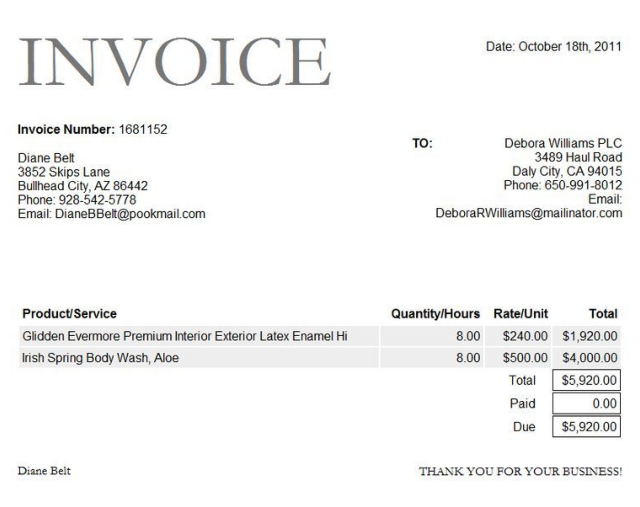

In [73]:
import matplotlib.pyplot as plt
from PIL import Image

document_path = DATA_INPUT / "test_en.jpg"

def visualize_document(image_path):
    image = Image.open(image_path)
    
    plt.figure(figsize=(8, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

visualize_document(document_path)

In [74]:
recognize_text_tesseract(DATA_INPUT / "test_en.jpg")

'INVOICE\n\nInvoice Number: 1681152\n\nDiane Bett\n3852 Skips Lane\n\nBullhead City, AZ 86442\n\nPhone: 928-542-5778\n\nEmail: DianeBBett@pookmail. com\n\nProduct/Service\nGlidden Evermore Premium Interior Exterior Latex Enamel Hi\nIrish Spring Body Wash, Aloe\n\nDiane Belt\n\nDate: October 18th, 2011\n\nTo: Debora Williams PLC\n3489 Haul Road\n\nDaly City, CA 94015\n\nPhone: 650-991-8012\n\nEmai\nDeboraRWilliams@mailinator.com\n\nQuantityiHours Rate/Unit Total\n8.00 $240.00 $1,920.00\n\n8.00 $500.00 $4,000.00\n\nTotal $5,920.00\n\nPaid 0.00\n\nDue | $5,920.00\n\nTHANK YOU FOR YOUR BUSINESS!'

In [75]:
result = classify_document(DATA_INPUT / "test_en.jpg", cache_dir=DATA_CACHE)
print("Document Classification:", result)

d:\Projects\env_ml\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\Projects\env_ml\.venv\Lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Document Classification: {'predicted_class': 0}


In [76]:
extracted_info = extract_key_information(DATA_INPUT / "test_en.jpg", cache_dir=DATA_CACHE)
print("Extracted Information:", extracted_info)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Extracted Information: {'extracted_text': 'IN VO ICE  Inv oice  Number :  168 11 52  Diane  Bett  38 52  Sk ips  Lane  Bull  City ,  AZ  8 64 42  Phone :  9 28 - 5 42 - 5 778  Email :  Diane BB ett @ p ook mail .  com  Product / Service  Gl idden  Ever more  Premium  Interior  Ex terior  Late x  En amel  Hi  Irish  Spring  Body  Wash ,  Al  Diane  Belt  Date :  October  18 th ,  2011  To :  Debor a  Williams  P LC  3 489  H aul  Road  Daly  City ,  CA  94 015  Phone :  650 - 99 1 - 8 012  Em ai  Debor a R Williams @ mail inator . com  Quantity i Hours  Rate / Unit  Total  8 . 00  $ 240 . 00  $ 1 , 920 . 00  8 . 00  $ 500 . 00  $ 4 , 000 . 00  Total  $ 5 , 920 . 00  Paid  0 . 00  Due  |  $ 5 , 920 . 00  THANK  YOU  FOR  YOUR  BUS INESS !'}


In [77]:
qa_result = answer_document_question(DATA_INPUT / "test_en.jpg", "What invoice number?", cache_dir=DATA_CACHE)
print("Answer:", qa_result)

Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-large and are newly initialized: ['qa_outputs.dense.bias', 'qa_outputs.dense.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Answer: {'answer': 'ĠTHANK ĠYOU ĠFOR ĠYOUR ĠBUS INESS ! </s>'}


## layoutlmv3 Ru

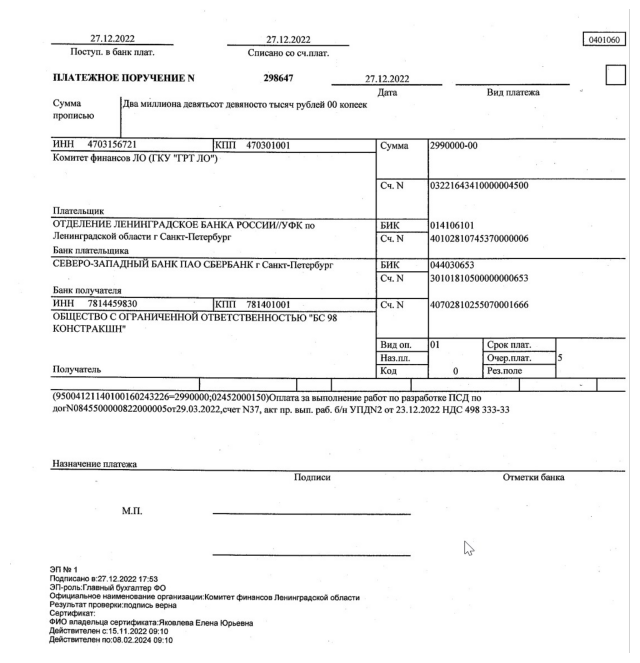

In [78]:
import matplotlib.pyplot as plt
from PIL import Image

document_path = DATA_INPUT / "test_ru.jpg"

def visualize_document(image_path):
    image = Image.open(image_path)
    
    plt.figure(figsize=(8, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

visualize_document(document_path)

In [91]:
recognize_text_tesseract(DATA_INPUT / "test_ru_3.jpg", lang='rus')

'Соглашение о расторжении\nКонтракта № СТ-1383/22 от 31.01.2022 г.\nна поставку наборов для катетеризации на 2022 год\n\nпос. Первомайское «30» декабря 2022 г.\n\nГосударственное бюджетное учреждение здравоохранения Ленинградской ласти «Рощинская\nмежрайонная больница» (ГБУЗ ЛО «Рощинская МБ»), именуемое в дальнейшем «Заказчик», в лице\nтлавного врача Казарова Эрнеста Эдуардовича, действующего на основании Устава, Общество с\nограниченной ответственностью «Болюсмед» (ООО «Болюсмед»), именуемое в дальнейшем\n«Поставщик», в лице генерального директора Беловой Христины Витальевны, действующего на\nосновании Устава, с другой стороны, здесь и далее именуемые «Стороны», заключили настоящее\nСоглашение к Контракту № СТ-1383/22 от 31.01.2022 г. о нижеследующем:\n\n1. Руководствуясь частью 8 статьи 95 ФЗ №44-ФЗ «О контрактной системе в сфере закупок товаров, работ,\n‘услуг для обеспечения государственных и муниципальных нужд», пунктом 1 статьи 450 ГКРФ и пунктами\n11.2, 11.3. Контракта № СТ-138

In [80]:
# result = classify_document(DATA_INPUT / "test_ru.jpg", cache_dir=DATA_CACHE)
# print("Document Classification:", result)

In [81]:
# extracted_info = extract_key_information(DATA_INPUT / "test_ru.jpg", cache_dir=DATA_CACHE)
# print("Extracted Information:", extracted_info)

In [82]:
# qa_result = answer_document_question(DATA_INPUT / "test_ru.jpg", "What invoice number?", cache_dir=DATA_CACHE)
# print("Answer:", qa_result)

## Easyocr

In [83]:
import torch
import easyocr
from PIL import Image
from pathlib import Path


from transformers import LayoutLMv3Processor, LayoutLMv3ForSequenceClassification
from typing import Dict, List

# Инициализация EasyOCR
reader = easyocr.Reader(["en", "ru"])  # Поддержка английского и русского


def recognize_text_easyocr(image_path: str) -> str:
    """
    Распознает текст с изображения с помощью EasyOCR.

    :param image_path: Путь к изображению
    :return: Распознанный текст
    """
    results = reader.readtext(str(image_path), detail=0)
    return " ".join(results)

def recognize_text_and_boxes(image_path: str) -> Dict[str, List]:
    """
    Распознает текст с изображения с помощью EasyOCR и извлекает координаты bounding boxes.

    :param image_path: Путь к изображению
    :return: Словарь {'text': [список слов], 'boxes': [список координат]}
    """
    results = reader.readtext(str(image_path), detail=1)  # Получаем текст + bounding boxes

    words = []
    boxes = []
    
    for (bbox, text, _confidence) in results:
        x_min, y_min = bbox[0]  # Верхний левый угол
        x_max, y_max = bbox[2]  # Нижний правый угол
        words.append(text)
        boxes.append([x_min, y_min, x_max, y_max])

    return {"text": words, "boxes": boxes}


def normalize_boxes(boxes: List[List[int]], width: int, height: int) -> List[List[int]]:
    """
    Нормализует bounding boxes в диапазон 0-1000 (как требует LayoutLMv3).

    :param boxes: Исходные координаты (x_min, y_min, x_max, y_max)
    :param width: Ширина изображения
    :param height: Высота изображения
    :return: Нормализованные координаты
    """
    return [[
        int(1000 * (x_min / width)),
        int(1000 * (y_min / height)),
        int(1000 * (x_max / width)),
        int(1000 * (y_max / height)),
    ] for x_min, y_min, x_max, y_max in boxes]


def classify_document(image_path: str, cache_dir: Path, model_name="microsoft/layoutlmv3-large") -> Dict:
    """
    Классификация документа с помощью LayoutLMv3.

    :param image_path: Путь к изображению документа
    :param cache_dir: Директория для кеширования модели
    :param model_name: Название модели LayoutLMv3
    :return: Классификация документа (словарь)
    """
    processor = LayoutLMv3Processor.from_pretrained(model_name, cache_dir=cache_dir, apply_ocr=False)
    model = LayoutLMv3ForSequenceClassification.from_pretrained(model_name, cache_dir=cache_dir).to("cuda" if torch.cuda.is_available() else "cpu")

    # Извлекаем текст и bounding boxes
    extracted_data = recognize_text_and_boxes(image_path)
    words, boxes = extracted_data["text"], extracted_data["boxes"]
    print(words)

    # Загружаем изображение
    image = Image.open(image_path).convert("RGB")
    width, height = image.size

    # Нормализуем bounding boxes
    normalized_boxes = normalize_boxes(boxes, width, height)

    # Подготавливаем данные
    encoding = processor(images=image, text=words, boxes=normalized_boxes, return_tensors="pt").to(model.device)

    # Предсказание
    with torch.no_grad():
        outputs = model(**encoding)

    # Получаем предсказанный класс
    predicted_class = outputs.logits.argmax(-1).item()
    
    return {"predicted_class": predicted_class}



def extract_key_information(image_path: str, cache_dir: Path, model_name="microsoft/layoutlmv3-large") -> Dict:
    """
    Извлечение ключевой информации из документа.

    :param image_path: Путь к изображению документа
    :param cache_dir: Директория для кеширования модели
    :param model_name: Название модели LayoutLMv3
    :return: Извлеченные данные (словарь)
    """
    from transformers import LayoutLMv3ForTokenClassification

    processor = LayoutLMv3Processor.from_pretrained(model_name, cache_dir=cache_dir, apply_ocr=False)
    model = LayoutLMv3ForTokenClassification.from_pretrained(model_name, cache_dir=cache_dir).to("cuda" if torch.cuda.is_available() else "cpu")

    # Извлекаем текст и bounding boxes
    extracted_data = recognize_text_and_boxes(image_path)
    words, boxes = extracted_data["text"], extracted_data["boxes"]
    print(words)

    # Загружаем изображение
    image = Image.open(image_path).convert("RGB")
    width, height = image.size

    # Нормализуем bounding boxes
    normalized_boxes = normalize_boxes(boxes, width, height)

    # Подготавливаем данные
    encoding = processor(images=image, text=words, boxes=normalized_boxes, return_tensors="pt").to(model.device)

    # Предсказание
    with torch.no_grad():
        outputs = model(**encoding)

    # Получаем предсказанные метки токенов
    predictions = outputs.logits.argmax(-1).tolist()[0]

    # Декодируем текст
    tokens = processor.tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze().tolist())
    extracted_info = " ".join([tokens[i] for i in range(len(tokens)) if predictions[i] != 0])

    return {"extracted_info": extracted_info}


def answer_document_question(image_path: str, question: str, cache_dir: Path, model_name="microsoft/layoutlmv3-large") -> Dict:
    """
    Ответ на вопрос по документу (DocVQA).

    :param image_path: Путь к изображению документа
    :param question: Вопрос по документу
    :param cache_dir: Директория для кеширования модели
    :param model_name: Название модели LayoutLMv3
    :return: Текстовый ответ на вопрос
    """
    from transformers import LayoutLMv3ForQuestionAnswering

    processor = LayoutLMv3Processor.from_pretrained(model_name, cache_dir=cache_dir, apply_ocr=False)
    model = LayoutLMv3ForQuestionAnswering.from_pretrained(model_name, cache_dir=cache_dir).to("cuda" if torch.cuda.is_available() else "cpu")

    # Извлекаем текст и bounding boxes
    extracted_data = recognize_text_and_boxes(image_path)
    words, boxes = extracted_data["text"], extracted_data["boxes"]
    print(words)

    # Загружаем изображение
    image = Image.open(image_path).convert("RGB")
    width, height = image.size

    # Нормализуем bounding boxes
    normalized_boxes = normalize_boxes(boxes, width, height)

    # Подготавливаем данные
    encoding = processor(images=image, text=words, boxes=normalized_boxes, return_tensors="pt").to(model.device)

    # Предсказание
    with torch.no_grad():
        outputs = model(**encoding)

    # Получаем индекс начала и конца ответа
    start_idx = outputs.start_logits.argmax(-1).item()
    end_idx = outputs.end_logits.argmax(-1).item()

    # Декодируем текст ответа
    tokens = processor.tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze().tolist())
    answer_text = " ".join(tokens[start_idx:end_idx + 1])

    return {"answer": answer_text}

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [84]:
recognize_text_easyocr(DATA_INPUT / "test_en.jpg")

'Date: October 18th, 2011 INVOICE Invoice Number: 1681152 ТO: Debora Williams PLC Diane Belt 3489 Haul Road 3852 Skips Lane Daly City; CA 94015 Bullhead City; AZ 86442 Phone: 650-991-8012 Phone: 928-542-5778 Email: Email: DianeBBel@pookmail com DeboraRWilliams@mailinator com ProductService QuantitylHours RatelUnit Total Glidden Evermore Premium Interior Exterior Latex Enamel Hi 8.00 $240.00 51,920.00 Irish Spring Body Wash; Aloe 8.00 5500.00 54,000.00 Tolal 55,920.00 Paid 0.00 Due 55,920.00 Dize Belt THNLNKYOL FOR YOLR BLSIESS:'

In [85]:
result = classify_document(DATA_INPUT / "test_en.jpg", cache_dir=DATA_CACHE)
print("Document Classification:", result)

d:\Projects\env_ml\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['Date: October 18th, 2011', 'INVOICE', 'Invoice Number: 1681152', 'ТO:', 'Debora Williams PLC', 'Diane Belt', '3489 Haul Road', '3852 Skips Lane', 'Daly City; CA 94015', 'Bullhead City; AZ 86442', 'Phone: 650-991-8012', 'Phone: 928-542-5778', 'Email:', 'Email: DianeBBel@pookmail com', 'DeboraRWilliams@mailinator com', 'ProductService', 'QuantitylHours', 'RatelUnit', 'Total', 'Glidden Evermore Premium Interior Exterior Latex Enamel Hi', '8.00', '$240.00', '51,920.00', 'Irish Spring Body Wash; Aloe', '8.00', '5500.00', '54,000.00', 'Tolal', '55,920.00', 'Paid', '0.00', 'Due', '55,920.00', 'Dize Belt', 'THNLNKYOL FOR YOLR BLSIESS:']


d:\Projects\env_ml\.venv\Lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Document Classification: {'predicted_class': 0}


In [86]:
extracted_info = extract_key_information(DATA_INPUT / "test_en.jpg", cache_dir=DATA_CACHE)
print("Extracted Information:", extracted_info)

d:\Projects\env_ml\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['Date: October 18th, 2011', 'INVOICE', 'Invoice Number: 1681152', 'ТO:', 'Debora Williams PLC', 'Diane Belt', '3489 Haul Road', '3852 Skips Lane', 'Daly City; CA 94015', 'Bullhead City; AZ 86442', 'Phone: 650-991-8012', 'Phone: 928-542-5778', 'Email:', 'Email: DianeBBel@pookmail com', 'DeboraRWilliams@mailinator com', 'ProductService', 'QuantitylHours', 'RatelUnit', 'Total', 'Glidden Evermore Premium Interior Exterior Latex Enamel Hi', '8.00', '$240.00', '51,920.00', 'Irish Spring Body Wash; Aloe', '8.00', '5500.00', '54,000.00', 'Tolal', '55,920.00', 'Paid', '0.00', 'Due', '55,920.00', 'Dize Belt', 'THNLNKYOL FOR YOLR BLSIESS:']


d:\Projects\env_ml\.venv\Lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Extracted Information: {'extracted_info': 'ĠDate : th Ġ2011 ĠIN ĠNumber : Ġ168 52 ĠDiane ĠBelt ĠH aul Ġ38 ĠSk ĠLane ĠDaly ; Ġ94 head ĠCity ; ĠAZ Ġ8 64 42 : - : 28 - : : ĠDiane B Bel p mail ĠProduct ĠQuantity l l ĠTotal ĠGl more Ġ51 , 920 ; Ġ54 , 000 al Ġ55 , 920 Ġ55 , 920 ĠD ĠBelt NL N OL ĠB LS :'}


In [87]:
qa_result = answer_document_question(DATA_INPUT / "test_en.jpg", "What invoice number?", cache_dir=DATA_CACHE)
print("Answer:", qa_result)

d:\Projects\env_ml\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of LayoutLMv3ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv3-large and are newly initialized: ['qa_outputs.dense.bias', 'qa_outputs.dense.weight', 'qa_outputs.out_proj.bias', 'qa_outputs.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['Date: October 18th, 2011', 'INVOICE', 'Invoice Number: 1681152', 'ТO:', 'Debora Williams PLC', 'Diane Belt', '3489 Haul Road', '3852 Skips Lane', 'Daly City; CA 94015', 'Bullhead City; AZ 86442', 'Phone: 650-991-8012', 'Phone: 928-542-5778', 'Email:', 'Email: DianeBBel@pookmail com', 'DeboraRWilliams@mailinator com', 'ProductService', 'QuantitylHours', 'RatelUnit', 'Total', 'Glidden Evermore Premium Interior Exterior Latex Enamel Hi', '8.00', '$240.00', '51,920.00', 'Irish Spring Body Wash; Aloe', '8.00', '5500.00', '54,000.00', 'Tolal', '55,920.00', 'Paid', '0.00', 'Due', '55,920.00', 'Dize Belt', 'THNLNKYOL FOR YOLR BLSIESS:']


d:\Projects\env_ml\.venv\Lib\site-packages\transformers\modeling_utils.py:1126: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Answer: {'answer': 'Ġ8 64 42 ĠPhone : Ġ650 - 99 1 - 8 012 ĠPhone : Ġ9 28 - 5 42 - 5 778 ĠEmail : ĠEmail : ĠDiane B Bel @ p ook mail Ġcom ĠDebor a R Williams @ mail inator Ġcom ĠProduct Service ĠQuantity l Hours ĠRate l Unit ĠTotal ĠGl idden ĠEver more ĠPremium ĠInterior ĠEx terior ĠLate x ĠEn amel ĠHi Ġ8 . 00 Ġ$ 240 . 00 Ġ51 , 920 . 00 ĠIrish ĠSpring ĠBody ĠWash ; ĠAl oe Ġ8 . 00 Ġ5 500 . 00 Ġ54 , 000 . 00 ĠTol al Ġ55 , 920 . 00 ĠPaid Ġ0 . 00 ĠDue Ġ55 , 920 . 00 ĠD ize ĠBelt ĠTH NL N KY OL ĠFOR ĠY OL R ĠB LS I ESS : </s>'}


In [88]:
recognize_text_easyocr(DATA_INPUT / "test_ru_2.jpg")

'АКТ ОКАЗАННЫХ УСЛУГ Ng 301201 от 30 декабря 202Zr: ПО ГОСУДАРСТВЕННОМУ КОНТРАКТУ Ng 157/21 Hа окаланне услуг по компексному сопровоженню технологнческого имущества органов нсполнипТеЛЬНОЙ шласти Ленинградской области Заказчик: Управлсннс дсламн Правнтельства Ленннградской области; 191311, г. Санкт-Петербург: Суворовский проспскт: д 67 Исполннтель; ООО ЖКСП:   195027. Санкт-Петербург FH: тер муннципальный}   округ   Большая   Охта Магнитогарская ул, дам N 5] . лигера ₽  помещенне 1H JH офнс 309.334-90-08 Исполнитсль оказал; Заказчнк принял следующне_услуги: Нанменонанне Кол Ед ям . Цена Сумып Услуги по комплексному меc 1905426,00 1905426,00 сопровожденню технологическаго имущества арганов нсполнительной пластн Ленннградской областн дскабрс 2022r Итого: 1905426 (Один миллион девятьсот пять тысяч четырсста дпадцать шесть) рублсй 00 копсск; НДС нс аблаглется СЕЯАН примененнем упрощенной системы налогообложения на основанни статын 346.1| главы 26.2 НК РФ. Услугн оказаны полном объеме; Прст

In [89]:
# result = classify_document(DATA_INPUT / "test_ru.jpg", cache_dir=DATA_CACHE)
# print("Document Classification:", result)

In [90]:
# extracted_info = extract_key_information(DATA_INPUT / "test_ru.jpg", cache_dir=DATA_CACHE)
# print("Extracted Information:", extracted_info)